In [1]:
import numpy as np
import random
import os

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf 

tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

### Loading data and preprocessing

In [3]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)
df['LogVolume'] = np.log(df['Volume'])
df['DiffLogVolume'] = df['LogVolume'].diff()
df.head()

,Volume,LogVolume,DiffLogVolume
Production Date,,,
2015-01-01,67515553.0,18.027869,NaN
2015-02-01,61664960.0,17.937226,-0.090642
2015-03-01,66342950.0,18.010348,0.073122
2015-04-01,67719040.0,18.030878,0.020530
2015-05-01,66484591.0,18.012481,-0.018397


### Supervised Dataset

In [4]:
series = df['DiffLogVolume'].to_numpy()[1:] 

T = 6
X = [] 
Y = []  
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y)
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (118, 6) Y.shape (118,)


### Train/Validation/Test Split

In [5]:
Ntest = 12  
Nval = 12 

Xtrain, Ytrain = X[:-Ntest-Nval], Y[:-Ntest-Nval]
Xval, Yval = X[-Ntest-Nval:-Ntest], Y[-Ntest-Nval:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:] 

train = df.iloc[T+1:T+1+len(Xtrain)] 
val = df.iloc[T+1+len(Xtrain):T+1+len(Xtrain)+len(Xval)]
test = df.iloc[T+1+len(Xtrain)+len(Xval):T+1+len(Xtrain)+len(Xval)+len(Xtest)] 

### Scaling

In [6]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler_x.fit_transform(Xtrain)
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)

Xval = scaler_x.transform(Xval)
Xval = Xval.reshape(Xval.shape[0], Xval.shape[1], 1)

Xtest = scaler_x.transform(Xtest)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

Ytrain = scaler_y.fit_transform(Ytrain.reshape(-1, 1))
Yval = scaler_y.transform(Yval.reshape(-1, 1))
Ytest = scaler_y.transform(Ytest.reshape(-1, 1))

### Indexing

In [7]:
train_idx = (df.index >= train.index[0]) & (df.index <= train.index[-1])
val_idx = (df.index >= val.index[0]) & (df.index <= val.index[-1])
test_idx = (df.index >= test.index[0]) & (df.index <= test.index[-1])

### Manual Grid Search

In [8]:
def build_and_train_lstm(units, dropout_rate, learning_rate, epochs, 
                         batch_size, loss_function='mse', seed=SEED):
    K.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed) 

    initializer = tf.keras.initializers.GlorotUniform(seed=seed)  

    model = Sequential([
        Input(shape =(T, 1)),
        LSTM(units, activation='tanh', return_sequences=True,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(dropout_rate, seed=SEED),
        LSTM(units, activation='tanh', return_sequences=False,
             kernel_initializer=initializer, recurrent_initializer=initializer,
            bias_initializer='zeros'),
        Dropout(dropout_rate, seed=SEED),
        Dense(1, kernel_initializer=initializer, bias_initializer='zeros')
    ])

    loss = tf.keras.losses.Huber(delta=1.0)
        
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=loss, 
                  metrics=['mae'])

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Stop if no improvement for 15 epochs
        restore_best_weights=True,  # Restore weights from best epoch
        verbose=0
    )
    
    history = model.fit(
        Xtrain, Ytrain,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(Xval, Yval),
        callbacks=[early_stop],
        verbose=0,
        shuffle=True
    )
    
    # Get final validation loss
    val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1
    
    return model, best_val_loss, best_epoch, history

In [9]:
# Define hyperparameter grid
hyperparameters = {
    'units': [ 40, 50, 64],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001],
    'epochs': [100],
    'batch_size': [8, 16],
    'loss_function': ['huber']
}

total_combinations = (len(hyperparameters['units']) * 
                     len(hyperparameters['dropout_rate']) * 
                     len(hyperparameters['learning_rate']) * 
                     len(hyperparameters['epochs']) * 
                     len(hyperparameters['batch_size']) * 
                     len(hyperparameters['loss_function']))

print(f"\n{'='*70}")
print(f"GRID SEARCH: {total_combinations} total combinations")
print(f"{'='*70}\n")

# Manual grid search
results = []
trial_num = 0

for units in hyperparameters['units']:
    for dropout in hyperparameters['dropout_rate']:
        for lr in hyperparameters['learning_rate']:
            for epochs in hyperparameters['epochs']:
                for batch_size in hyperparameters['batch_size']:
                    for loss_fn in hyperparameters['loss_function']:
                        
                        trial_num += 1
                        
                        print(f"[{trial_num}/{total_combinations}] Testing: "
                              f"units={units}, dropout={dropout}, lr={lr}, "
                              f"epochs={epochs}, batch={batch_size}, loss={loss_fn}")
                        
                        model, best_val_loss, best_epoch, history = build_and_train_lstm(
                            units, dropout, lr, epochs, batch_size, loss_function=loss_fn,
                            seed=SEED
                        )
                        
                        results.append({
                            'units': units,
                            'dropout': dropout,
                            'learning_rate': lr,
                            'epochs': epochs,
                            'batch_size': batch_size,
                            'loss_function': loss_fn,
                            'best_val_loss': best_val_loss,
                            'best_epoch': best_epoch
                        })
                        
                        print(f"  ✓ Best Val Loss: {best_val_loss:.6f} at epoch {best_epoch}\n")

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('best_val_loss')

print("\n" + "="*70)
print("TOP 5 CONFIGURATIONS:")
print("="*70)
print(results_df.head().to_string(index=False))

# Use best hyperparameters
best_params = results_df.iloc[0]
print("\n" + "="*70)
print("BEST CONFIGURATION:")
print("="*70)
for key, value in best_params.items():
    print(f"  {key}: {value}")
print("="*70) 


GRID SEARCH: 18 total combinations

[1/18] Testing: units=40, dropout=0.1, lr=0.001, epochs=100, batch=8, loss=huber

  ✓ Best Val Loss: 0.002214 at epoch 95

[2/18] Testing: units=40, dropout=0.1, lr=0.001, epochs=100, batch=16, loss=huber
  ✓ Best Val Loss: 0.002595 at epoch 96

[3/18] Testing: units=40, dropout=0.2, lr=0.001, epochs=100, batch=8, loss=huber
  ✓ Best Val Loss: 0.002222 at epoch 92

[4/18] Testing: units=40, dropout=0.2, lr=0.001, epochs=100, batch=16, loss=huber
  ✓ Best Val Loss: 0.002607 at epoch 96

[5/18] Testing: units=40, dropout=0.3, lr=0.001, epochs=100, batch=8, loss=huber
  ✓ Best Val Loss: 0.002285 at epoch 98

[6/18] Testing: units=40, dropout=0.3, lr=0.001, epochs=100, batch=16, loss=huber
  ✓ Best Val Loss: 0.002633 at epoch 96

[7/18] Testing: units=50, dropout=0.1, lr=0.001, epochs=100, batch=8, loss=huber
  ✓ Best Val Loss: 0.002178 at epoch 84

[8/18] Testing: units=50, dropout=0.1, lr=0.001, epochs=100, batch=16, loss=huber
  ✓ Best Val Loss: 0.00

In [10]:
print("\n" + "="*70)
print("RETRAINING BEST MODEL ON TRAIN+VAL")
print("="*70)

Xtrainval = np.concatenate([Xtrain, Xval], axis=0)
Ytrainval = np.concatenate([Ytrain, Yval], axis=0)

best_units = int(best_params['units'])
best_dropout = best_params['dropout']
best_lr = best_params['learning_rate']
best_epochs = int(best_params['epochs'])
best_batch = int(best_params['batch_size'])
best_loss = best_params['loss_function']

K.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

final_model = Sequential([
    Input(shape=(T, 1)),
    LSTM(best_units, activation='tanh', return_sequences=True,
         kernel_initializer=initializer,
         recurrent_initializer=initializer,
         bias_initializer='zeros'),
    Dropout(best_dropout, seed=SEED),
    LSTM(best_units, activation='tanh',
         kernel_initializer=initializer,
         recurrent_initializer=initializer,
         bias_initializer='zeros'),
    Dropout(best_dropout, seed=SEED),
    Dense(1, kernel_initializer=initializer,
          bias_initializer='zeros')
])
    
loss = tf.keras.losses.Huber(delta=1.0)

final_model.compile(optimizer=Adam(learning_rate=best_lr), 
                   loss=loss,
                   metrics=['mae'])

early_stop = EarlyStopping(
    monitor='loss', 
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("Training final model...")
final_history = final_model.fit(
    Xtrainval, Ytrainval,
    epochs=200,
    batch_size=best_batch,
    callbacks=[early_stop],
    verbose=1,
    shuffle=True
)

print("\n✓ Final model trained")


RETRAINING BEST MODEL ON TRAIN+VAL
Training final model...
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0571 - mae: 0.2859
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0206 - mae: 0.1557
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0190 - mae: 0.1459
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0176 - mae: 0.1412
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0174 - mae: 0.1365
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0172 - mae: 0.1371
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0166 - mae: 0.1371
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0166 - mae: 0.1378
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0185 - mae: 0.1425
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0169 - mae: 0.1358
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0160 - mae: 0.1355
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18m

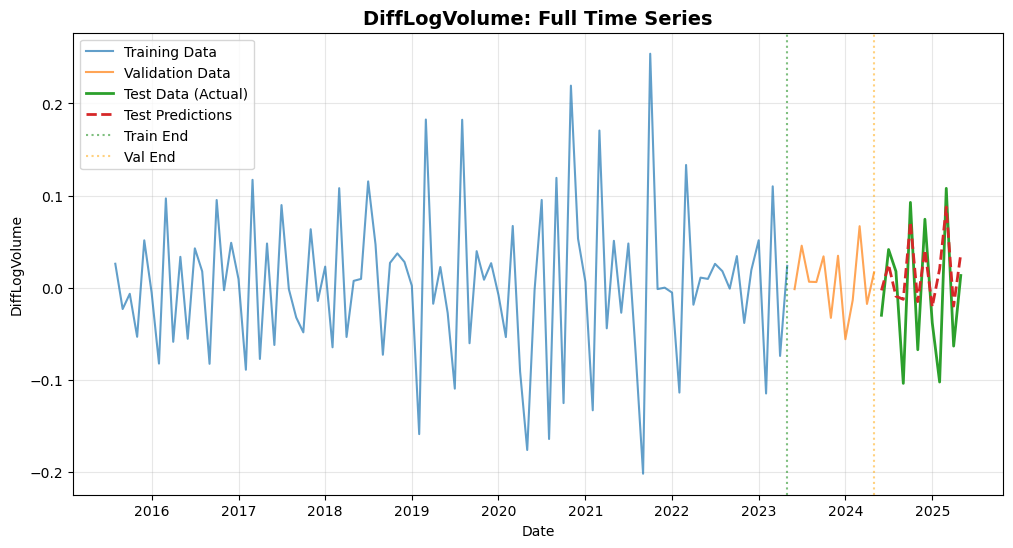

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train.index, df.loc[train.index, 'DiffLogVolume'], 
            label='Training Data', alpha=0.7)
ax.plot(val.index, df.loc[val.index, 'DiffLogVolume'], 
            label='Validation Data', alpha=0.7)
ax.plot(test.index, df.loc[test.index, 'DiffLogVolume'], 
            label='Test Data (Actual)', linewidth=2)
ax.plot(test.index, test_predictions.flatten(), 
            label='Test Predictions', linewidth=2, linestyle='--')
ax.axvline(train.index[-1], color='green', linestyle=':', alpha=0.5, label='Train End')
ax.axvline(val.index[-1], color='orange', linestyle=':', alpha=0.5, label='Val End')
ax.set_title('DiffLogVolume: Full Time Series', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('DiffLogVolume')
ax.legend()
ax.grid(True, alpha=0.3)